## Predicting mood from raw audio data - aka "Tagger"

Welcome to our most excellent music tagging project - lovingly codenamed "Tagger". Please see the coresponding tutorial to build your own tagger by checking out [this site]. A customer wanted their customers to find music based on mood or tags like "hopeful", "happy" or "sad". To date those tags were entered by humans and it lead to _good_, but at times inconsistent results. They wanted to find out: Could a deep neural network understand music and give it consistent labels based on the mood?

Let's find out!

[this site]: https://peltarion.com/knowledge-center/tutorials/predicting-mood-from-raw-audio-data

In [1]:
# If using http://colab.research.google.com uncomment the items below to add to your environment 
# !pip install librosa

In [1]:
import base64
import io

import IPython.display as ipd
import librosa as lr
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import PIL
import requests

%matplotlib inline

## Load a sample file for processing

We're loading a sample .mp3 file from the lovely royalty free music site [bensound.com] to show how we did the work to turn a song into a computer readable object, to base our classification work on.

Here we are reading in a song and creating a small player to allow us to judge the mood first.
[bensound.com]: https://www.bensound.com/royalty-free-music

In [2]:
# See the github repo music/ directory
song = 'music/00-www.bensound.com-CC-piano-cello.mp3'
audio, sample_rate = lr.load(song, sr=12000)
ipd.Audio(audio, rate=sample_rate)

## Take first 30 seconds

Let's cut the first 30 seconds from that sample (Any sample - please feel free to amend the code!) and prepare turning it into a picture.

In [3]:
audio_sample = audio[:(sample_rate * 30)]

## STFT to spectrogram
First we compute the [short-time Fourier transform] (STFT for short) of the audio signal. We then store the power of the magnitude as a picure called a spectrogram. As we can see most values show up as black due to the large differances in magnitude across frequencies and time.

[short-time Fourier transform]: https://en.wikipedia.org/wiki/Short-time_Fourier_transform

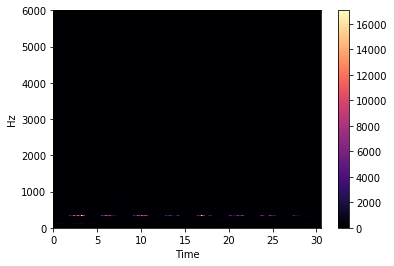

In [4]:
# Complex value STFT
stft = lr.stft(
    audio_sample,
    hop_length=500,
    n_fft=2048,
    center=False
)

# Real value spectrogram
spectrogram = np.abs(stft) ** 2.0

lr.display.specshow(spectrogram, x_axis='time', y_axis='hz', sr=sample_rate)
plt.colorbar()

## Spectrogram to mel scale and dB
Next we need to convert to the more compressed mel scale, where frequencies are weighed together in a way that is appropriate for music. Furthermore, the values are expressed in dB, a log based scale which compresses the range of each individual value. This allows us to more clearly see the song's inner structure. This is the final format used in the Tagger model and perfectly matches the Tagger training data.

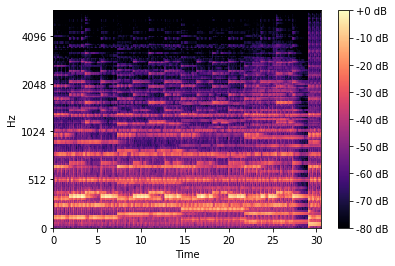

In [5]:
mel_basis = lr.filters.mel(sample_rate, n_fft=2048, n_mels=150, fmax=sample_rate/2)
mel_spectrogram = np.dot(mel_basis, spectrogram)
db_mel_spectrogram = lr.power_to_db(mel_spectrogram, ref=np.max)

lr.display.specshow(db_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, fmax=sample_rate/2)
plt.colorbar(format='%+2.0f dB')
plt.show()

# Request mood predictions

## Rescale to image
The spectrogram contains values in the range [-80, 0] (see the colorbar). To convert this to an image we need values from [0, 255], we therefore rescale to that interval.

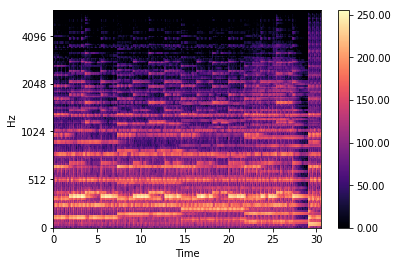

In [6]:
rescaled_db_mel_spectrogram = (db_mel_spectrogram + 80) / 80 * 255

lr.display.specshow(rescaled_db_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, fmax=sample_rate/2)
plt.colorbar(format='%.2f')
plt.show()

# Now compare the sound with the picture and see if you can follow along
# You can feel the 'black' at 27 seconds approach :)
ipd.Audio(audio_sample, rate=sample_rate)

## Create data-uri with spectrogram image
Notice how the image is mirrored such that the top corresponds to the lowest frequencies. This is due to how librosa shows spectrograms (indexed from high to low in the vertical direction) compared to how images are shown (indexed from low to high in the vertical direction).


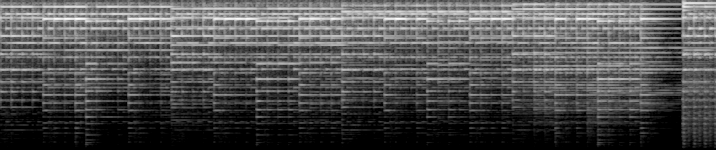

In [7]:
# Use pillow to create PNG without writing to file
image = PIL.Image.fromarray(rescaled_db_mel_spectrogram.astype(np.uint8))
image_bytes = io.BytesIO()
image.convert('L').save(image_bytes, format='png')

# Create data uri
spectrogram_data_uri = 'data:image/png;base64,' + base64.b64encode(image_bytes.getvalue()).decode('utf-8')

# Show
ipd.Image(url=spectrogram_data_uri)

In [8]:
# Uncomment and copy/paste everything between the ''s in the window below, in your browser to see what we're doing
#spectrogram_data_uri

## That's it!

You have just done a beautiful piece of data engineering in preparation for training your model. Please follow our very detailed music mood Tagger [tutorial] on how to build an operational AI model based on this work.

The final step is to create your own png file from a song you know and love, and use your own model to classify it.

[tutorial]: https://peltarion.com/knowledge-center/tutorials/predicting-mood-from-raw-audio-data

In [10]:
# Once you've trained your own model and created a deployment with a Rest endpoint, 
# use the credentials we provide in the fields below to test it directly from this notebook.

TOKEN = '--hidden--'
DATA = {'rows': [{'spectrogram': spectrogram_data_uri}]}
ENDPOINT = 'https://a.peltarion.com/deployment/--hidden--/forward'

response = requests.post(
    ENDPOINT,
    headers={'Authorization': 'Bearer %s' % TOKEN},
    json=DATA
)

response.json()

{'rows': [{'Angry': 0.00483741,
   'Busy & Frantic': 0.012631924,
   'Casino': 0.0001567012,
   'Changing Tempo': 0.011977006,
   'Chasing': 0.013137644,
   'Countryside': 0.005881373,
   'Dark': 0.060801648,
   'Dreamy': 0.39114243,
   'Eccentric': 0.009030297,
   'Elegant': 0.020958556,
   'Epic': 0.0732323,
   'Euphoric': 0.043514326,
   'Fear': 0.007097174,
   'Floating': 0.21778297,
   'Funny': 0.0018532287,
   'Glamorous': 0.0022483456,
   'Happy': 0.08086303,
   'Heavy & Ponderous': 0.005116226,
   'Hopeful': 0.32395187,
   'Industry': 0.00011624644,
   'Jungle': 0.00083309214,
   'Laid Back': 0.013027159,
   'Lounge': 0.0034485364,
   'Marching': 0.01083153,
   'Mysterious': 0.06324872,
   'Newsroom': 3.3701787e-07,
   'Peaceful': 0.20424928,
   'Public Places': 3.0966044e-07,
   'Quirky': 0.005216806,
   'Relaxing': 0.051590715,
   'Restless': 0.04600001,
   'Romantic': 0.07159174,
   'Running': 0.02136143,
   'Sad': 0.07321348,
   'Scary': 0.0025537799,
   'Sci-Fi & Space': 0